# Data processing

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np

In [2]:
import sys
import os
local_repo_path = os.path.abspath(os.path.join(os.getcwd(), 'world-models-fork'))
local_repo_path = os.path.abspath(os.path.join(os.getcwd(), '../world-models-fork'))
if local_repo_path not in sys.path:
    sys.path.append(local_repo_path)
from models.rssm import RSSM

import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
import os

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

In [4]:
MAX_ACTION_DIM = 18

In [5]:
tfrecord_files = [
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_1-00000-of-00050",
    #"gs://rl_unplugged/atari_episodes_ordered/Breakout/run_1-00000-of-00050",
    #"gs://rl_unplugged/atari_episodes_ordered/SpaceInvaders/run_1-00000-of-00050"
]

episodes_dataset = tf.data.TFRecordDataset(
    tfrecord_files,
    compression_type="GZIP",
    num_parallel_reads=tf.data.AUTOTUNE
)

In [6]:
def list_games(base_path):
    games = tf.io.gfile.listdir(base_path)
    games = [game.replace("_$folder$", "") for game in games if not game.endswith("_$folder$")]
    return games

base_path = "gs://rl_unplugged/atari_episodes_ordered/"
games = list_games(base_path)

print(f"{len(games)} Available games:")
for game in games:
    print(game)

46 Available games:
Alien/
Amidar/
Assault/
Asterix/
Atlantis/
BankHeist/
BattleZone/
BeamRider/
Boxing/
Breakout/
Carnival/
Centipede/
ChopperCommand/
CrazyClimber/
DemonAttack/
DoubleDunk/
Enduro/
FishingDerby/
Freeway/
Frostbite/
Gopher/
Gravitar/
Hero/
IceHockey/
Jamesbond/
Kangaroo/
Krull/
KungFuMaster/
MsPacman/
NameThisGame/
Phoenix/
Pong/
Pooyan/
Qbert/
Riverraid/
RoadRunner/
Robotank/
Seaquest/
SpaceInvaders/
StarGunner/
TimePilot/
UpNDown/
VideoPinball/
WizardOfWor/
YarsRevenge/
Zaxxon/


In [ ]:
"""
def get_tfrecord_files(base_path):
    games = tf.io.gfile.listdir(base_path)
    games = [game.replace("_$folder$", "") for game in games if not game.endswith("_$folder$")]
    tfrecord_files = []
    for game in games:
        game_path = tf.io.gfile.glob(f"{base_path}{game}run_1-*")
        if game_path:
            tfrecord_files.append(game_path[0])
            #if len(game_path) > 1:
            #    tfrecord_files.append(game_path[1])
    return tfrecord_files

tfrecord_files = get_tfrecord_files(base_path)

episodes_dataset = tf.data.TFRecordDataset(
    tfrecord_files,
    compression_type="GZIP",
    num_parallel_reads=tf.data.AUTOTUNE
)

print(f"Loaded {len(tfrecord_files)} TFRecord files: {tfrecord_files}")
"""

'\ndef get_tfrecord_files(base_path):\n    games = tf.io.gfile.listdir(base_path)\n    games = [game.replace("_$folder$", "") for game in games if not game.endswith("_$folder$")]\n    tfrecord_files = []\n    for game in games:\n        game_path = tf.io.gfile.glob(f"{base_path}{game}run_1-*")\n        if game_path:\n            tfrecord_files.append(game_path[0])\n            #if len(game_path) > 1:\n            #    tfrecord_files.append(game_path[1])\n    return tfrecord_files\n\ntfrecord_files = get_tfrecord_files(base_path)\n\nepisodes_dataset = tf.data.TFRecordDataset(\n    tfrecord_files,\n    compression_type="GZIP",\n    num_parallel_reads=tf.data.AUTOTUNE\n)\n\nprint(f"Loaded {len(tfrecord_files)} TFRecord files: {tfrecord_files}")\n'

: 

In [ ]:
episodes_dataset = episodes_dataset.shuffle(buffer_size=10)

for i, raw_example in enumerate(episodes_dataset.take(10)):
    example = tf.train.Example()
    example.ParseFromString(raw_example.numpy())
    obs = example.features.feature["observations"].bytes_list.value
    img = tf.io.decode_image(obs[0], channels=3)
    plt.imshow(img.numpy())
    plt.title(f"Random Sample {i+1}")
    plt.axis('off')
    plt.show()

In [ ]:
raw_example = next(iter(episodes_dataset))

example = tf.train.Example()
example.ParseFromString(raw_example.numpy())

print("Features in the TFRecord example:")
for key in example.features.feature.keys():
    feature = example.features.feature[key]
    if feature.bytes_list.value:
        dtype = "bytes"
    elif feature.int64_list.value:
        dtype = "int64"
    elif feature.float_list.value:
        dtype = "float"
    else:
        dtype = "unknown"
    print(f"{key}: {dtype}")

Features in the TFRecord example:
checkpoint_idx: int64
clipped_rewards: float
episode_idx: int64
episode_return: float
observations: bytes
discounts: float
unclipped_rewards: float
clipped_episode_return: float
actions: int64


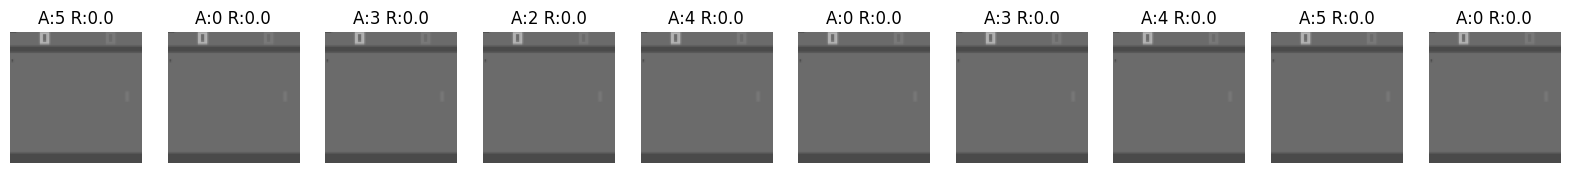

In [ ]:
feature_description = {
    "observations": tf.io.VarLenFeature(tf.string),
    "actions": tf.io.VarLenFeature(tf.int64),
    "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def parse_function(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)

    obs = tf.sparse.to_dense(parsed["observations"])
    actions = tf.sparse.to_dense(parsed["actions"])
    rewards = tf.sparse.to_dense(parsed["clipped_rewards"])

    img = tf.io.decode_image(obs[0], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img, actions[0], rewards[0]

dataset_parsed = episodes_dataset.map(parse_function)

plt.figure(figsize=(20, 4))
for i, (frame, action, reward) in enumerate(dataset_parsed.take(10)):
    plt.subplot(2, 10, i+1)
    plt.imshow(frame.numpy(), cmap=None)
    plt.axis('off')
    plt.title(f"A:{action.numpy()} R:{reward.numpy():.1f}")
plt.show()

In [ ]:
#!git clone https://github.com/FayalaMohamed/world-models-fork.git

In [ ]:
feature_description = {
  "observations": tf.io.VarLenFeature(tf.string),
  "actions": tf.io.VarLenFeature(tf.int64),
  "clipped_rewards": tf.io.VarLenFeature(tf.float32),
}

def parse_sequence(example_proto):
  parsed = tf.io.parse_single_example(example_proto, feature_description)
  obs = tf.sparse.to_dense(parsed["observations"])
  actions = tf.sparse.to_dense(parsed["actions"])
  rewards = tf.sparse.to_dense(parsed["clipped_rewards"])

  # Decode images and set explicit shape
  imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
  imgs.set_shape([None, None, None, 3])  # Set partial shape info

  imgs = tf.image.resize(imgs, [64, 64])
  imgs = tf.cast(imgs, tf.float32) / 255.0
  actions = tf.cast(actions, tf.int64)
  rewards = tf.cast(rewards, tf.float32)
  return imgs, actions, rewards

batch_size = 16
sequence_length = 50

dataset = episodes_dataset.map(parse_sequence)
dataset = dataset.filter(lambda imgs, actions, rewards: tf.shape(imgs)[0] >= sequence_length)

def extract_non_overlapping_sequences(imgs, actions, rewards, skip=1):
    episode_length = tf.shape(imgs)[0]
    num_sequences = episode_length // sequence_length

    if num_sequences > 0:
        trimmed_length = num_sequences * sequence_length
        imgs_trimmed = imgs[:trimmed_length]
        actions_trimmed = actions[:trimmed_length]
        rewards_trimmed = rewards[:trimmed_length]

        imgs_sequences = tf.reshape(imgs_trimmed, [num_sequences, sequence_length, 64, 64, 3])
        actions_sequences = tf.reshape(actions_trimmed, [num_sequences, sequence_length])
        rewards_sequences = tf.reshape(rewards_trimmed, [num_sequences, sequence_length])
        
        imgs_sequences = imgs_sequences[::skip]
        actions_sequences = actions_sequences[::skip]
        rewards_sequences = rewards_sequences[::skip]

        return tf.data.Dataset.from_tensor_slices((imgs_sequences, actions_sequences, rewards_sequences))
    else:
        return tf.data.Dataset.from_tensor_slices((
            tf.zeros((0, sequence_length, 64, 64, 3), dtype=tf.float32),
            tf.zeros((0, sequence_length), dtype=tf.int64),
            tf.zeros((0, sequence_length), dtype=tf.float32)
        ))

dataset = dataset.map(extract_non_overlapping_sequences)
dataset = dataset.flat_map(lambda x: x)  # Flatten the nested datasets
dataset = dataset.batch(batch_size, drop_remainder=True)

Instructions for updating:
Use fn_output_signature instead


(912, 64, 64, 3)
(912,)
(912,)


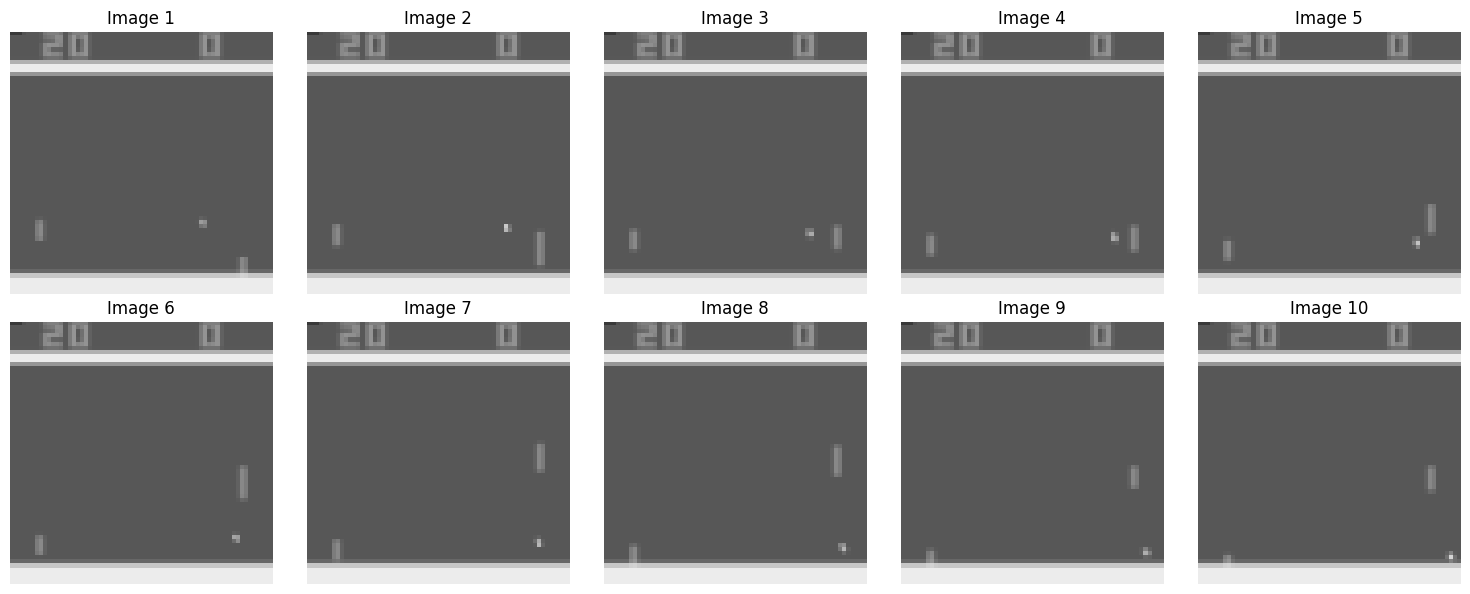

In [ ]:

example = next(iter(episodes_dataset.take(1)))
imgs, actions, rewards = parse_sequence(example)

print(imgs.shape)
print(actions.shape)
print(rewards.shape)

last_ten_imgs = imgs[-10:]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
  ax.imshow(last_ten_imgs[i], vmin=0, vmax=1)
  ax.set_title(f"Image {i+1}")
  ax.axis("off")
plt.tight_layout()
plt.show()


imgs: (16, 50, 64, 64, 3)
actions: (16, 50)
rewards: (16, 50)
Instructions for updating:
Use tf.identity with explicit device placement instead.


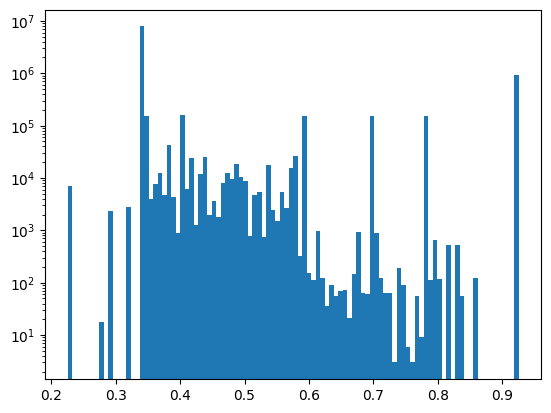

In [ ]:
for imgs, actions, rewards in dataset.take(1):
  print("imgs:", imgs.shape)
  print("actions:", actions.shape)
  print("rewards:", rewards.shape)
  vals = imgs.cpu().numpy().flatten()
  plt.hist(vals, bins=100, log=True)
  plt.show()

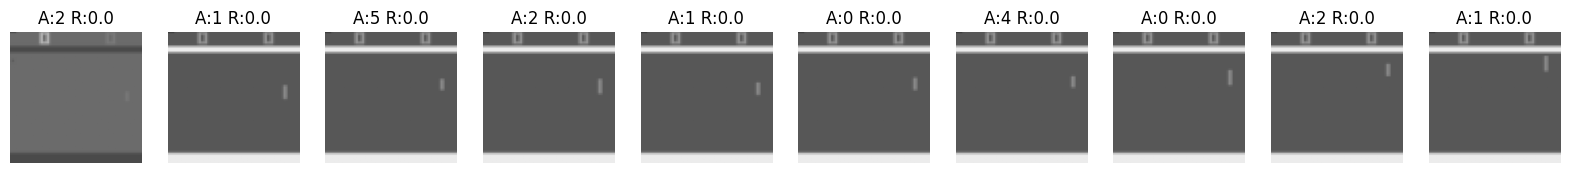

In [ ]:
for imgs, actions, rewards in dataset.take(1):
  seq_imgs = imgs[0]
  seq_actions = actions[0]
  seq_rewards = rewards[0]

  plt.figure(figsize=(20, 4))
  for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(seq_imgs[i].numpy())
    plt.axis("off")
    plt.title(f"A:{seq_actions[i].numpy()} R:{seq_rewards[i].numpy():.1f}")
  plt.show()

In [ ]:
def parse_sequence_for_inspection(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    obs = tf.sparse.to_dense(parsed["observations"])
    imgs = tf.map_fn(lambda x: tf.io.decode_image(x, channels=3), obs, dtype=tf.uint8)
    print("Original image shape (before resizing):", imgs.shape)
    return imgs

example = next(iter(episodes_dataset.take(1)))
imgs = parse_sequence_for_inspection(example)

Original image shape (before resizing): (961, 84, 84, 3)


In [ ]:
class AtariSequenceDataset(Dataset):
  def __init__(self, tf_dataset, num_batches):
    self.data = []
    for i, (imgs, actions, rewards) in enumerate(tf_dataset):
      if i >= num_batches:
        break
      self.data.append((
        imgs.numpy(), actions.numpy(), rewards.numpy()
      ))
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    imgs, actions, rewards = self.data[idx]
    imgs = torch.tensor(imgs, dtype=torch.float32)  # [seq, W, H, 3]
    actions = torch.tensor(actions, dtype=torch.long)  # [seq]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # [seq]
    return imgs, actions, rewards

In [ ]:
num_batches = 500
num_batches = 100
num_batches = 1000
atari_dataset = AtariSequenceDataset(dataset, num_batches)
dataloader = DataLoader(atari_dataset, batch_size=1, shuffle=True)

In [ ]:
print("=== Dataset Size Information ===")
print(f"Number of batches: {len(atari_dataset)}")

sample_batch = atari_dataset[0]
imgs, actions, rewards = sample_batch
print(f"Shape of images in one batch: {imgs.shape}")
print(f"Shape of actions in one batch: {actions.shape}")
print(f"Shape of rewards in one batch: {rewards.shape}")

batch_size_in_dataset = imgs.shape[0]
sequence_length_per_example = imgs.shape[1]
total_examples = len(atari_dataset) * batch_size_in_dataset

print(f"\n=== Breakdown ===")
print(f"Sequences per batch: {batch_size_in_dataset}")
print(f"Frames per sequence: {sequence_length_per_example}")
print(f"Total sequences (examples): {total_examples}")
print(f"Total frames: {total_examples * sequence_length_per_example}")


=== Dataset Size Information ===
Number of batches: 100
Shape of images in one batch: torch.Size([16, 50, 64, 64, 3])
Shape of actions in one batch: torch.Size([16, 50])
Shape of rewards in one batch: torch.Size([16, 50])

=== Breakdown ===
Sequences per batch: 16
Frames per sequence: 50
Total sequences (examples): 1600
Total frames: 80000


In [ ]:
sample_batch = next(iter(dataset.take(1)))
sample_imgs = sample_batch[0]
print(f"Actual image shape in dataset: {len(sample_batch)}")
print(f"Actual image shape in dataset: {sample_imgs.shape}")
print(f"Individual image shape: {sample_imgs[0, 0].shape}")

Actual image shape in dataset: 3
Actual image shape in dataset: (16, 50, 64, 64, 3)
Individual image shape: (64, 64, 3)


In [ ]:
from models.models import EncoderCNN, DecoderCNN, RewardModel
from models.rssm import RSSM
from models.dynamics import DynamicsModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

action_dim = MAX_ACTION_DIM
hidden_size = 1024
state_size = 32
encoder_embedding_dim = 1024
image_height, image_width = sample_imgs.shape[2], sample_imgs.shape[3]

encoder = EncoderCNN(
    in_channels=3,
    embedding_dim=encoder_embedding_dim,
    input_shape=(image_height, image_width)
).to(device)

decoder = DecoderCNN(
    hidden_size=hidden_size,
    state_size=state_size,
    embedding_size=encoder_embedding_dim,
    use_bn=True,
    output_shape=(3, image_height, image_width)
).to(device)

reward_model = RewardModel(hidden_size, state_size).to(device)

dynamics_model = DynamicsModel(
    hidden_dim=hidden_size,
    action_dim=action_dim,
    state_dim=state_size,
    embedding_dim=encoder_embedding_dim
).to(device)

rssm = RSSM(
    encoder,
    decoder,
    reward_model,
    dynamics_model,
    hidden_size,
    state_size,
    action_dim,
    encoder_embedding_dim,
    device=device
)

optimizer = torch.optim.Adam(rssm.parameters(), lr=3e-4, weight_decay=1e-5)

print(f"Model created successfully:")
print(f"  - Action dim: {action_dim}")
print(f"  - Hidden size: {hidden_size}")
print(f"  - State size: {state_size}")
print(f"  - Embedding size: {encoder_embedding_dim}")
print(f"  - Image shape: (3, {image_height}, {image_width})")

total_params = sum(p.numel() for p in rssm.parameters() if p.requires_grad)
print(f"  - Total parameters: {total_params:,}")

Using device: cuda
Model created successfully:
  - Action dim: 6
  - Hidden size: 1024
  - State size: 32
  - Embedding size: 1024
  - Image shape: (3, 64, 64)
  - Total parameters: 22,010,757


# Modified Trainer for Dataset Usage

Instead of using an Agent that collects data from an environment, we'll create a modified Trainer that can work directly with our preprocessed Atari dataset.

In [ ]:
from tqdm import tqdm
import math

class AtariTrainer:
    def __init__(self, rssm: RSSM, dataloader, optimizer, device):
        self.rssm = rssm
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.device = device

    def train_batch(self, imgs: torch.Tensor, actions: torch.Tensor, rewards: torch.Tensor, iteration: int, reconstruction_loss_fn: str="mse", save_images: bool=False):
        """
        Train on a single batch from the dataset
        Args:
            imgs: (batch_size, seq_len, height, width, channels)
            actions: (batch_size, seq_len)
            rewards: (batch_size, seq_len)
        """
        batch_size, seq_len = imgs.shape[0], imgs.shape[1]
        imgs = imgs.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)

        actions = torch.nn.functional.one_hot(actions, self.rssm.action_dim).float()

        # (batch_size, seq_len, H, W, C) -> (batch_size*seq_len, C, H, W)
        imgs_reshaped = imgs.reshape(-1, *imgs.shape[2:]).permute(0, 3, 1, 2).contiguous()

        encoded_obs = self.rssm.encoder(imgs_reshaped)
        encoded_obs = encoded_obs.reshape(batch_size, seq_len, -1)

        # Generate RSSM rollout
        rollout = self.rssm.generate_rollout(actions, obs=encoded_obs)
        hiddens, prior_states, posterior_states, prior_means, prior_logvars, posterior_means, posterior_logvars = rollout

        # Reconstruct observations
        hiddens_reshaped = hiddens.reshape(batch_size * seq_len, -1)
        posterior_states_reshaped = posterior_states.reshape(batch_size * seq_len, -1)

        decoded_obs = self.rssm.decoder(hiddens_reshaped, posterior_states_reshaped)
        decoded_obs = decoded_obs.reshape(batch_size, seq_len, *imgs.shape[-3:])

        # Predict rewards
        reward_params = self.rssm.reward_model(hiddens, posterior_states)
        reward_mean, reward_logvar = torch.chunk(reward_params, 2, dim=-1)

        # Clamp reward logvar to prevent extreme values
        reward_logvar = torch.clamp(reward_logvar, min=-10, max=10)
        reward_std = torch.exp(0.5 * reward_logvar) + 1e-6
        reward_dist = torch.distributions.Normal(reward_mean, reward_std)
        predicted_rewards = reward_dist.rsample()

        # Calculate losses
        if reconstruction_loss_fn == "mse":
            reconstruction_loss = torch.nn.functional.mse_loss(decoded_obs, imgs)
        elif reconstruction_loss_fn == "mae":
            reconstruction_loss = torch.nn.functional.l1_loss(decoded_obs, imgs)
        elif reconstruction_loss_fn == "huber":
            reconstruction_loss = torch.nn.functional.smooth_l1_loss(decoded_obs, imgs)
        else:
            raise ValueError(f"Unknown reconstruction loss function: {reconstruction_loss_fn}")

        prior_std = torch.exp(0.5 * prior_logvars) + 1e-6
        posterior_std = torch.exp(0.5 * posterior_logvars) + 1e-6
        prior_dist = torch.distributions.Normal(prior_means, prior_std)
        posterior_dist = torch.distributions.Normal(posterior_means, posterior_std)
        kl_loss = torch.distributions.kl_divergence(posterior_dist, prior_dist).mean()

        reward_loss = torch.nn.functional.mse_loss(predicted_rewards, rewards.unsqueeze(-1))

        total_loss = reconstruction_loss + kl_loss + reward_loss

        # Optimization step
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.rssm.parameters(), 1.0)
        self.optimizer.step()

        # Optional visualization
        if save_images:
            self._visualize(imgs, decoded_obs, rewards, predicted_rewards,
                          batch_idx=0, seq_idx=0, reconstruction_loss_fn=reconstruction_loss_fn, iterations=iteration, grayscale=False)

        return total_loss.item(), reconstruction_loss.item(), kl_loss.item(), reward_loss.item()

    def train(self, num_epochs, reconstruction_loss_fn="mse"):
        """Train the model for specified number of epochs"""
        self.rssm.train()

        global_step = 0
        last_loss = float("inf")
        best_model_path = "checkpoints/rssm_best.pth"
        history = []

        for epoch in range(num_epochs):
            print(f"Starting epoch {epoch+1}/{num_epochs}")
            epoch_losses = []

            progress_bar = tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", disable=True)

            for batch_idx, (imgs, actions, rewards) in enumerate(progress_bar):
                # Remove extra batch dimension from dataloader
                # from [1, 16, 50, 64, 64, 3] to [16, 50, 64, 64, 3]
                imgs = imgs.squeeze(0)
                actions = actions.squeeze(0)
                rewards = rewards.squeeze(0)

                total_loss, recon_loss, kl_loss, reward_loss = self.train_batch(
                    imgs, actions, rewards, global_step, reconstruction_loss_fn=reconstruction_loss_fn, save_images=(global_step % 2000 == 0)
                )
                history.append((global_step, total_loss, recon_loss, kl_loss, reward_loss))

                # Skip this batch if we got invalid losses
                if any(math.isinf(loss) or math.isnan(loss) for loss in [total_loss, recon_loss, kl_loss, reward_loss]):
                    print(f"Skipping batch {batch_idx} due to invalid loss values")
                    continue

                epoch_losses.append(total_loss)
                
                # Save the best model directly to a file
                if total_loss < last_loss:
                    torch.save({
                        'dynamics': self.rssm.dynamics.state_dict(),
                        'encoder': self.rssm.encoder.state_dict(),
                        'decoder': self.rssm.decoder.state_dict(),
                        'reward_model': self.rssm.reward_model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'loss': total_loss
                    }, best_model_path)
                    last_loss = total_loss


                progress_bar.set_postfix({
                    'Total Loss': f'{total_loss:.4f}',
                    'Recon': f'{recon_loss:.4f}',
                    'KL': f'{kl_loss:.4f}',
                    'Reward': f'{reward_loss:.4f}'
                })

                global_step += 1

            avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
            print(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")

            if epoch % 5 == 0:
                self.rssm.save(f'checkpoints/rssm/rssm_checkpoint_epoch_{epoch+1}.pth')
                torch.save({
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': avg_epoch_loss
                }, f'checkpoints/optimizer/optimizer_checkpoint_epoch_{epoch+1}.pth')

        best_checkpoint = torch.load(best_model_path, weights_only=True)

        self.rssm.dynamics.load_state_dict(best_checkpoint['dynamics'])
        self.rssm.encoder.load_state_dict(best_checkpoint['encoder'])
        self.rssm.decoder.load_state_dict(best_checkpoint['decoder'])
        self.rssm.reward_model.load_state_dict(best_checkpoint['reward_model'])
        self.optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])

        print("Best model loaded with loss:", best_checkpoint['loss'])


        return self.rssm, history

    def _visualize(self, obs, decoded_obs, rewards, predicted_rewards, batch_idx, seq_idx, iterations: int, reconstruction_loss_fn: str, grayscale: bool = True):
        obs = obs[batch_idx, seq_idx: seq_idx + 3]
        decoded_obs = decoded_obs[batch_idx, seq_idx: seq_idx + 3]

        rewards = rewards[batch_idx, seq_idx: seq_idx + 3]
        predicted_rewards = predicted_rewards[batch_idx, seq_idx: seq_idx + 3]

        obs = obs.cpu().detach().numpy()
        decoded_obs = decoded_obs.cpu().detach().numpy()

        rewards = rewards.cpu().detach().numpy()
        predicted_rewards = predicted_rewards.cpu().detach().numpy()

        fig, axs = plt.subplots(3, 2, figsize=(10, 12))
        axs[0][0].imshow(obs[0, ..., 0], cmap="gray")
        axs[0][0].set_title(f"Iteration: {iterations} -- Reward: {rewards[0]:.4f}")
        axs[0][0].axis("off")
        axs[0][1].imshow(decoded_obs[0, ..., 0], cmap="gray")
        axs[0][1].set_title(f"Pred. Reward: {predicted_rewards[0, 0]:.4f}")

        axs[0][1].axis("off")

        axs[1][0].imshow(obs[1, ..., 0], cmap="gray")
        axs[1][0].axis("off")
        axs[1][0].set_title(f"Reward: {rewards[1]:.4f} -- reconstruction_loss_fn: {reconstruction_loss_fn}")
        axs[1][1].imshow(decoded_obs[1, ..., 0], cmap="gray")
        axs[1][1].set_title(f"Pred. Reward: {predicted_rewards[1, 0]:.4f}")
        axs[1][1].axis("off")

        axs[2][0].imshow(obs[2, ..., 0], cmap="gray")
        axs[2][0].axis("off")
        axs[2][0].set_title(f"Reward: {rewards[2]:.4f} -- reconstruction_loss_fn: {reconstruction_loss_fn}")
        axs[2][1].imshow(decoded_obs[2, ..., 0], cmap="gray")
        axs[2][1].set_title(f"Pred. Reward: {predicted_rewards[2, 0]:.4f}")
        axs[2][1].axis("off")

        plt.tight_layout()
        plt.show()

In [ ]:
def plot_losses_3(history):
    steps  = [h[0] for h in history]
    total  = [h[1] for h in history]
    recon  = [h[2] for h in history]
    kl     = [h[3] for h in history]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(steps, total)
    axes[0].set_title("total loss")

    axes[1].plot(steps, recon)
    axes[1].set_title("recon loss")

    axes[2].plot(steps, kl)
    axes[2].set_title("kl loss")

    for ax in axes:
        ax.set_xlabel("step")

    plt.tight_layout()
    plt.show()


In [ ]:
atari_trainer = AtariTrainer(
    rssm=rssm,
    dataloader=dataloader,
    optimizer=optimizer,
    device=device,
)

print("AtariTrainer created successfully!")
print(f"Dataset size: {len(atari_dataset)} batches")
print(f"Device: {device}")
print(f"Model parameters: {sum(p.numel() for p in rssm.parameters()):,} total")
print("\n Starting training...")

AtariTrainer created successfully!
Dataset size: 100 batches
Device: cuda
Model parameters: 22,010,757 total

 Starting training...


In [ ]:
#atari_trainer.train(num_epochs=10)

In [ ]:
def get_new_atari_trainer(optimizer_cls, **optim_kwargs):
    encoder_new = EncoderCNN(
        in_channels=3,
        embedding_dim=encoder_embedding_dim,
        input_shape=(image_height, image_width)
    ).to(device)
    decoder_new = DecoderCNN(
        hidden_size=hidden_size,
        state_size=state_size,
        embedding_size=encoder_embedding_dim,
        use_bn=True,
        output_shape=(3, image_height, image_width)
    ).to(device)
    reward_model_new = RewardModel(hidden_size, state_size).to(device)
    dynamics_model_new = DynamicsModel(
        hidden_dim=hidden_size,
        action_dim=action_dim,
        state_dim=state_size,
        embedding_dim=encoder_embedding_dim
    ).to(device)
    rssm_new = RSSM(
        encoder_new,
        decoder_new,
        reward_model_new,
        dynamics_model_new,
        hidden_size,
        state_size,
        action_dim,
        encoder_embedding_dim,
        device=device
    )
    optimizer_new = optimizer_cls(rssm_new.parameters(), **optim_kwargs)
    atari_trainer_new = AtariTrainer(
        rssm=rssm_new,
        dataloader=dataloader,
        optimizer=optimizer_new,
        device=device,
    )
    return atari_trainer_new

Starting epoch 1/1


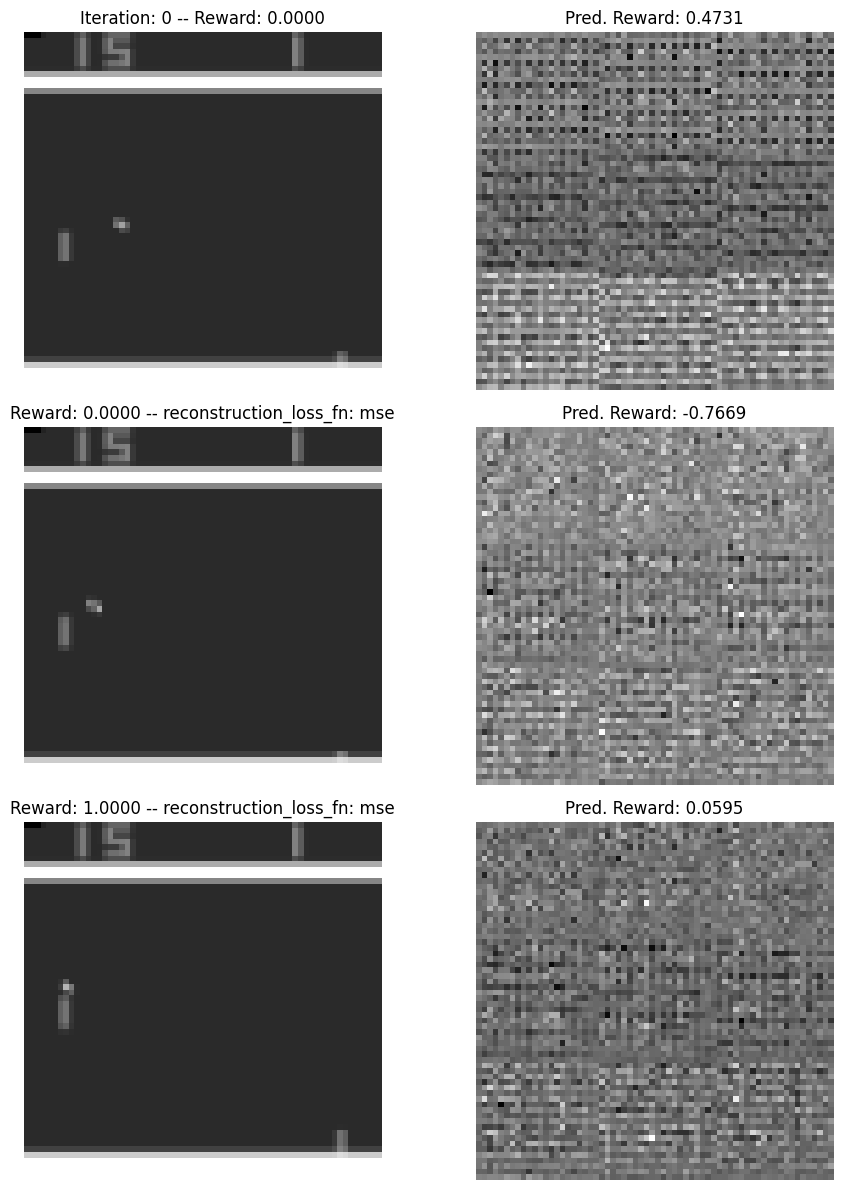

Epoch 1 completed. Average loss: 0.2147
Best model loaded with loss: 0.03786717355251312


In [ ]:
atari_trainer_new = get_new_atari_trainer()
best_rssm, history = atari_trainer_new.train(num_epochs=10)
plot_losses_3(history)

In [ ]:
"""
losses = ["mae", "huber", "mse"]
losses = ["mse"]
for recons_loss in losses:
    print(f"\n\n=== Training with reconstruction loss: {recons_loss} ===")
    atari_trainer_new = get_new_atari_trainer()

    best_rssm_2 = atari_trainer_new.train(num_epochs=30, reconstruction_loss_fn=recons_loss)
"""

'\nlosses = ["mae", "huber", "mse"]\nlosses = ["mse"]\nfor recons_loss in losses:\n    print(f"\n\n=== Training with reconstruction loss: {recons_loss} ===")\n    atari_trainer_new = get_new_atari_trainer()\n\n    best_rssm_2 = atari_trainer_new.train(num_epochs=30, reconstruction_loss_fn=recons_loss)\n'

# Optimizer experiments

In [ ]:
adam_grid = [
    dict(lr=3e-4, weight_decay=1e-5),
    dict(lr=1e-4, weight_decay=1e-5),
    dict(lr=3e-4, weight_decay=0),
    dict(lr=1e-3, weight_decay=1e-5),
]

In [ ]:
results = []
for params in adam_grid:
    trainer = get_new_atari_trainer(torch.optim.Adam, **params)
    _, hist = trainer.train(num_epochs=50)
    results.append(("adam", params, hist))

# Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.82317036..0.9562304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9035604..3.053588].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8177428..3.9122767].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2440338..3.3758874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.340904..3.9279094].


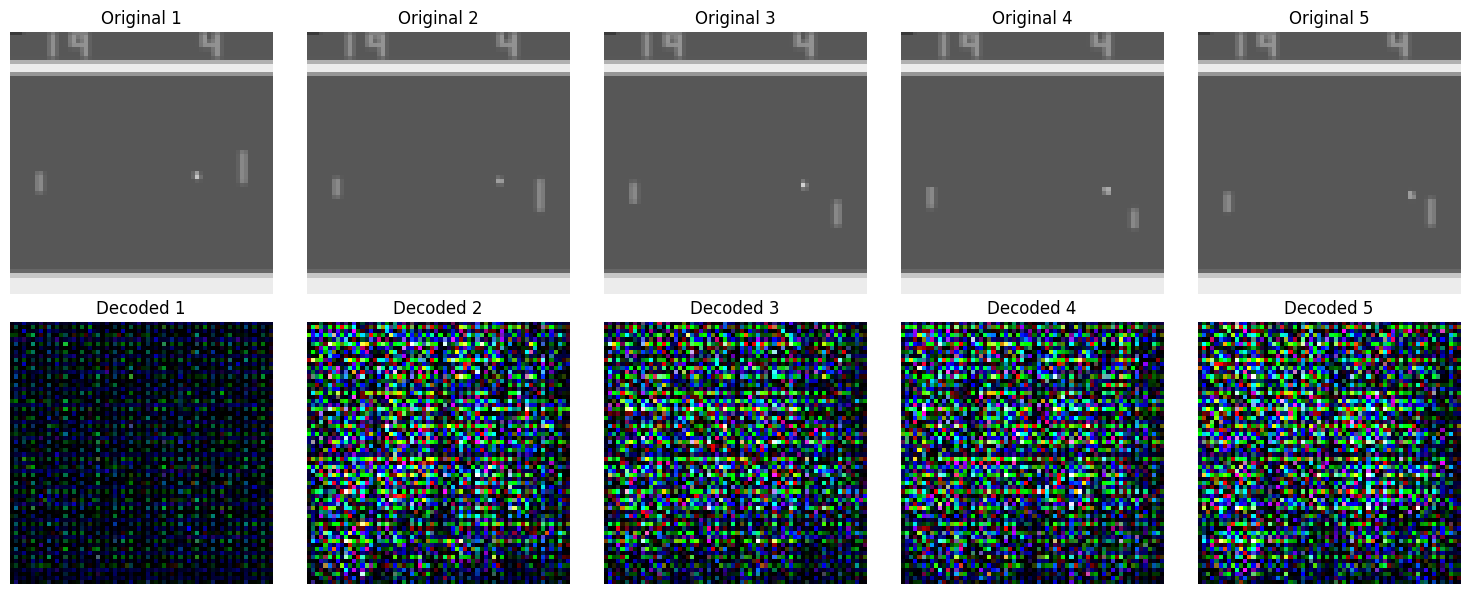

In [ ]:
best_rssm.eval()

inference_tfrecord_files = [
    "gs://rl_unplugged/atari_episodes_ordered/Pong/run_2-00001-of-00050"
]

inference_dataset = tf.data.TFRecordDataset(
    inference_tfrecord_files,
    compression_type="GZIP",
    num_parallel_reads=tf.data.AUTOTUNE
)

inference_dataset = inference_dataset.map(parse_sequence)
inference_dataset = inference_dataset.batch(1)

for imgs, actions, rewards in inference_dataset.take(1):
    imgs = imgs.numpy()  # Convert to numpy for visualization
    imgs_tensor = torch.tensor(imgs, dtype=torch.float32).permute(0, 1, 4, 2, 3).to(device)  # [B, T, C, H, W]

    # Flatten the batch and sequence dimensions for encoding
    batch_size, seq_len = imgs_tensor.shape[:2]
    imgs_flat = imgs_tensor.reshape(-1, *imgs_tensor.shape[2:]).contiguous()

    # Encode and decode using the RSSM
    with torch.no_grad():
        encoded_obs = rssm.encoder(imgs_flat)
        encoded_obs_seq = encoded_obs.reshape(batch_size, seq_len, -1)
        
        # Create dummy actions (zeros) for the rollout
        dummy_actions = torch.zeros(batch_size, seq_len, action_dim).to(device)
        
        hiddens, _, posterior_states, _, _, _, _ = rssm.generate_rollout(
            actions=dummy_actions, obs=encoded_obs_seq
        )
        decoded_obs = rssm.decoder(hiddens.reshape(-1, hiddens.shape[-1]), posterior_states.reshape(-1, posterior_states.shape[-1]))
        decoded_obs = decoded_obs.reshape(batch_size, seq_len, *imgs_tensor.shape[2:]).permute(0, 1, 3, 4, 2).cpu().numpy()

    # Plot original vs decoded images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axes[0, i].imshow(imgs[0, i])
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis("off")

        axes[1, i].imshow(decoded_obs[0, i])
        axes[1, i].set_title(f"Decoded {i+1}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()